In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Importing and cleaning data

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
na_counts = train.isna().sum()
na_counts

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
train['Sex'] = train['Sex'].map({'male':0,'female':1})
train.fillna({'Embarked': train['Embarked'].mode()[0],
              'Age': train['Age'].median()}, inplace=True)
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)


## 1. Baseline model

In [5]:
features = ['Pclass','Sex','Age','Fare','Embarked_Q','Embarked_S']
X = train[features]
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
baseline = LogisticRegression(max_iter=500, random_state=42)
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)

In [7]:
from sklearn.metrics import accuracy_score, classification_report
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_baseline))
print("Baseline Logistic Regression Report:")
print(classification_report(y_val, y_pred_baseline))

Baseline Logistic Regression Accuracy: 0.770949720670391
Baseline Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       110
           1       0.72      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



## 2. Feature engineering

In [8]:
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,False,False,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,False,True,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,False,True,Mr


In [9]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [10]:
rare_titles = ['Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer']
train['Title'] = train['Title'].replace(rare_titles,'Rare')

In [11]:
title_mapping = {"Mr":0, "Mrs":1, "Miss":2, "Rare":3 }
train['Title'] = train['Title'].map(title_mapping)

In [12]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = 1*(train['FamilySize']==1)

In [13]:
train['Cabin_letter'] = train['Cabin'].str.extract(r'([A-Za-z])')
train['Cabin_letter'].unique()
Cabins = {'C':0, 'E':1, 'G':2, 'D':3, 'A':4, 'B':5, 'F':6, 'T':7}
train['Cabin_letter'] = train['Cabin_letter'].map(Cabins)

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,Title,FamilySize,IsAlone,Cabin_letter
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,0,2,0,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,False,False,1,2,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,2,1,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,False,True,1,2,0,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,False,True,0,1,1,NaN


In [15]:
features = ['Pclass','Sex','Age','Fare','Title','FamilySize','IsAlone','Embarked_Q','Embarked_S']
X = train[features]
y = train['Survived']


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


## 3. Logistic regression

In [17]:
logistic_regression = LogisticRegression(max_iter=500, random_state=42)
features_no_na = ['Pclass','Sex','Age','Fare','Title','FamilySize','IsAlone','Embarked_Q','Embarked_S']
logistic_regression.fit(X_train[features_no_na], y_train)
y_pred_logistic_regression = logistic_regression.predict(X_val[features_no_na])

from sklearn.metrics import accuracy_score, classification_report
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_logistic_regression))
print("Logistic Regression Report:")
print(classification_report(y_val, y_pred_logistic_regression))

Logistic Regression Accuracy: 0.8026905829596412
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       137
           1       0.76      0.71      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



## 4. XGB Classifier

In [18]:
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[3,4,5],
    'learning_rate':[0.05,0.1],
    'subsample':[0.8,1]
}

In [19]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
cv = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_xgb = best_model.predict(X_val)

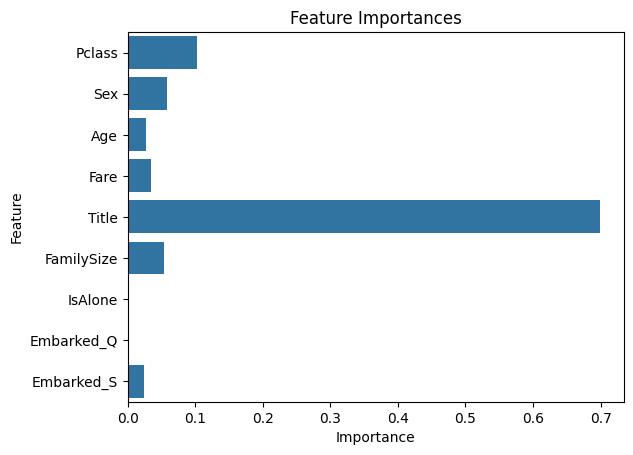

In [20]:
importances = best_model.feature_importances_
df_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

sns.barplot(data=df_importances, x='Importance', y='Feature')
plt.title("Feature Importances")
plt.show()

In [21]:
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("XGBoost Report:")
print(classification_report(y_val, y_pred_xgb))

XGBoost Accuracy: 0.8026905829596412
XGBoost Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       137
           1       0.81      0.64      0.71        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223



## 5. Random Forest Classifier

In [22]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True)
random_forest = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_val)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [23]:
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_random_forest))
print("Random Forest Report:")
print(classification_report(y_val, y_pred_random_forest))

Random Forest Accuracy: 0.7982062780269058
Random Forest Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       137
           1       0.79      0.65      0.71        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.79       223



## 6. Ensemble methods

In [24]:
proba_xgb = best_model.predict_proba(X_val)[:,1]
proba_rf = random_forest.predict_proba(X_val)[:,1]
proba_baseline = logistic_regression.predict_proba(X_val[features_no_na])[:,1]

proba_ensemble = (proba_xgb + proba_rf + proba_baseline) / 3
y_pred_ensemble = (proba_ensemble > 0.50).astype(int)

print("Ensemble Accuracy:", accuracy_score(y_val, y_pred_ensemble))
print("Ensemble Report:")
print(classification_report(y_val, y_pred_ensemble))

Ensemble Accuracy: 0.8161434977578476
Ensemble Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



## 7. Neural networks

In [25]:
X_train.values

array([[1, 1, 35.0, ..., 0, False, True],
       [2, 0, 19.0, ..., 1, False, True],
       [2, 0, 34.0, ..., 1, False, True],
       ...,
       [3, 1, 48.0, ..., 0, False, True],
       [1, 0, 47.0, ..., 1, False, True],
       [3, 0, 27.0, ..., 1, False, True]], dtype=object)

In [26]:
for col in X_train.columns:
    if X_train[col].dtype == 'bool':
        X_train[col] = X_train[col].astype(int)
        X_val[col] = X_val[col].astype(int)

In [27]:
X_train.values

array([[ 1.,  1., 35., ...,  0.,  0.,  1.],
       [ 2.,  0., 19., ...,  1.,  0.,  1.],
       [ 2.,  0., 34., ...,  1.,  0.,  1.],
       ...,
       [ 3.,  1., 48., ...,  0.,  0.,  1.],
       [ 1.,  0., 47., ...,  1.,  0.,  1.],
       [ 3.,  0., 27., ...,  1.,  0.,  1.]])

In [28]:
#now with pytorch neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)
class TitanicNN(nn.Module):
    def __init__(self, input_size):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_nn = TitanicNN(input_size=X_train.shape[1])
criterion = nn.BCELoss() #Binary Cross Entropy Loss
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)
num_epochs = 200
for epoch in range(num_epochs):
    model_nn.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad() # Zero the gradients
        outputs = model_nn(inputs)
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward() # Backpropagation
        optimizer.step() # Update the weights
    if (epoch+1) % 25 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
model_nn.eval()
with torch.no_grad():
    y_pred_nn = model_nn(X_val_tensor)
    y_pred_nn = (y_pred_nn.numpy() > 0.5).astype(int)
print("Neural Network Accuracy:", accuracy_score(y_val, y_pred_nn))


Epoch [25/200], Loss: 0.4338
Epoch [50/200], Loss: 0.5005
Epoch [75/200], Loss: 0.4469
Epoch [100/200], Loss: 0.3439
Epoch [125/200], Loss: 0.3436
Epoch [150/200], Loss: 0.2840
Epoch [175/200], Loss: 0.2501
Epoch [200/200], Loss: 0.2602
Neural Network Accuracy: 0.7937219730941704


## 8. Models comparsion

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       137
           1       0.76      0.71      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



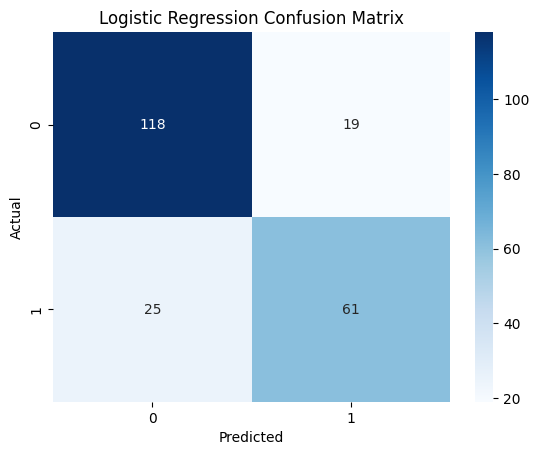

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       137
           1       0.79      0.65      0.71        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.79       223



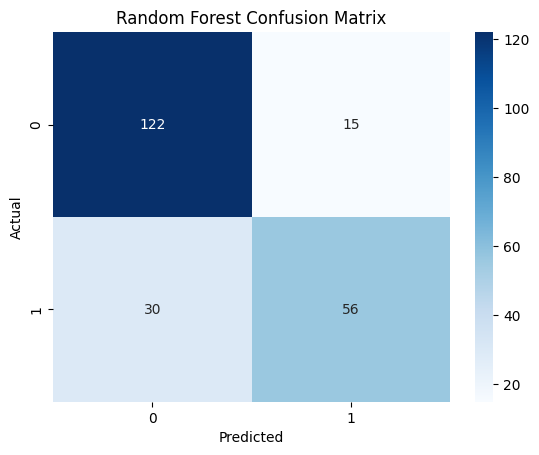

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       137
           1       0.81      0.64      0.71        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223



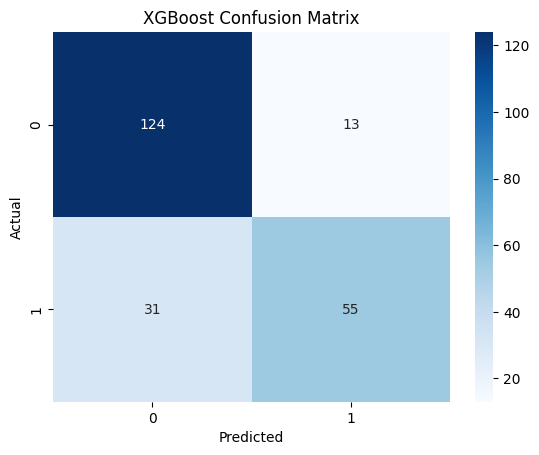

--- Neural Network ---
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       137
           1       0.82      0.59      0.69        86

    accuracy                           0.79       223
   macro avg       0.80      0.76      0.77       223
weighted avg       0.80      0.79      0.79       223



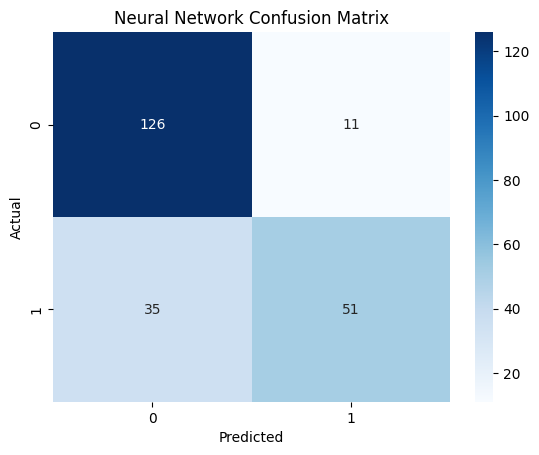

--- Ensemble ---
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



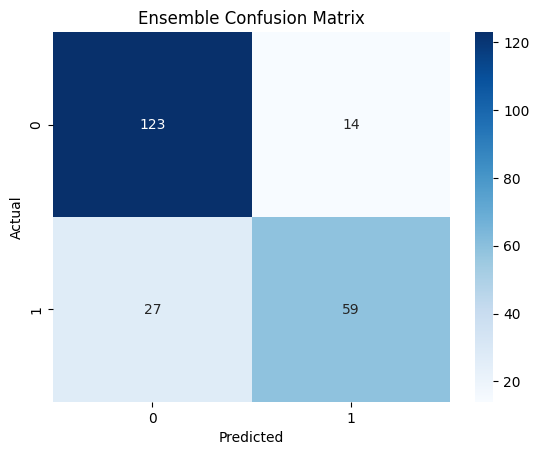

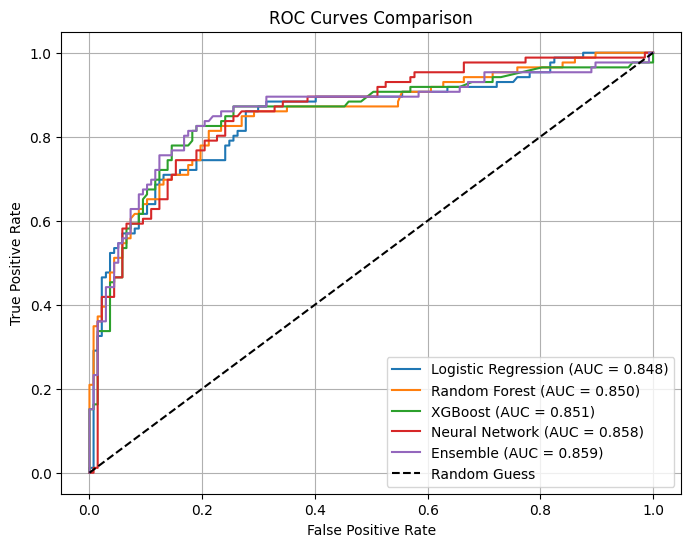

In [29]:
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_all_roc(models, X_val, y_val, title="ROC Curves Comparison"):
    plt.figure(figsize=(8,6))
    
    for name, model in models.items():
        if name == "Neural Network":
            model.eval()
            with torch.no_grad():
                y_proba = model(X_val_tensor).numpy().flatten()
        elif name == "Logistic Regression":
            y_proba = model.predict_proba(X_val[features_no_na])[:, 1]
        elif name == "Ensemble":
            y_proba = (
                logistic_regression.predict_proba(X_val[features_no_na])[:, 1] +
                random_forest.predict_proba(X_val)[:, 1] +
                best_model.predict_proba(X_val)[:, 1]
            ) / 3
        else:
            y_proba = model.predict_proba(X_val)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred_nn = (model_nn(X_val_tensor).numpy().flatten() > 0.5).astype(int)

models_with_preds = {
    "Logistic Regression": (logistic_regression, y_pred_logistic_regression),
    "Random Forest": (random_forest, y_pred_random_forest),
    "XGBoost": (best_model, y_pred_xgb),
    "Neural Network": (model_nn, y_pred_nn),
    "Ensemble": (None, y_pred_ensemble)
}

for name, (model, y_pred_model) in models_with_preds.items():
    print(f"--- {name} ---")
    print(classification_report(y_val, y_pred_model))
    plot_cm(y_val, y_pred_model, title=f"{name} Confusion Matrix")


models_for_roc = {
    "Logistic Regression": logistic_regression,
    "Random Forest": random_forest,
    "XGBoost": best_model,
    "Neural Network": model_nn,
    "Ensemble": None
}

plot_all_roc(models_for_roc, X_val, y_val)


## 9. Evauating model on test set

In [30]:
test = pd.read_csv('test.csv')
test['Sex'] = test['Sex'].map({'male':0,'female':1})
test.fillna({'Embarked': test['Embarked'].mode()[0],
              'Age': test['Age'].median()}, inplace=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
display(test['Title'].unique())
rare_titles = ['Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona']
test['Title'] = test['Title'].replace(rare_titles,'Rare')
test['Title'] = test['Title'].map(title_mapping)
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = 1*(test['FamilySize']==1)
test['Cabin_letter'] = test['Cabin'].str.extract(r'([A-Za-z])')
display(test['Cabin_letter'].unique())
Cabins = {'C':0, 'E':1, 'G':2, 'D':3, 'A':4, 'B':5, 'F':6, 'T':7}
test['Cabin_letter'] = test['Cabin_letter'].map(Cabins)

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

array([nan, 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

In [31]:
X_test = test[features]
X_test

,Pclass,Sex,Age,Fare,Title,FamilySize,IsAlone,Embarked_Q,Embarked_S
0,3,0,34.5,7.8292,0,1,1,True,False
1,3,1,47.0,7.0000,1,2,0,False,True
2,2,0,62.0,9.6875,0,1,1,True,False
3,3,0,27.0,8.6625,0,1,1,False,True
4,3,1,22.0,12.2875,1,3,0,False,True
...,...,...,...,...,...,...,...,...,...
413,3,0,27.0,8.0500,0,1,1,False,True
414,1,1,39.0,108.9000,3,1,1,False,False
415,3,0,38.5,7.2500,0,1,1,False,True
416,3,0,27.0,8.0500,0,1,1,False,True


In [32]:
proba_xgb = best_model.predict_proba(X_test)[:,1]
proba_rf = random_forest.predict_proba(X_test)[:,1]
proba_baseline = logistic_regression.predict_proba(X_test[features_no_na])[:,1]

test_ensemble = (proba_xgb + proba_rf + proba_baseline) / 3
y_test_ensemble = (test_ensemble > 0.50).astype(int)
y_test_ensemble
test['Survived'] = y_test_ensemble
result = test[['PassengerId', 'Survived']]


In [33]:
#neural network on test set
for col in X_test.columns:
    if X_test[col].dtype == 'bool':
        X_test[col] = X_test[col].astype(int)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
model_nn.eval()
with torch.no_grad():
    y_test_nn = model_nn(X_test_tensor)
    y_test_nn = (y_test_nn.numpy() > 0.5).astype(int)
test['Survived'] = y_test_nn
result_nn = test[['PassengerId', 'Survived']]
result_nn.reset_index(drop=True)
result_nn


/var/folders/m6/lt2vtzlx7q16z7m2rk2sjjs40000gn/T/ipykernel_16948/4055850605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype(int)
/var/folders/m6/lt2vtzlx7q16z7m2rk2sjjs40000gn/T/ipykernel_16948/4055850605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype(int)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [34]:
result_nn.to_csv('titanic_nn_submission.csv', index=False)
result_nn['Survived'].value_counts()

Survived
0    285
1    133
Name: count, dtype: int64

This submission achieves accuracy of **0.75837** on test set.

In [35]:
result.reset_index(drop=True)
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [36]:
result.to_csv('submission.csv', index=False)
result['Survived'].value_counts()

Survived
0    275
1    143
Name: count, dtype: int64

This submission achieves accuracy of **0.78229** on test set.